Using this article as example to help internalize metropolis hastings [here](https://towardsdatascience.com/from-scratch-bayesian-inference-markov-chain-monte-carlo-and-metropolis-hastings-in-python-ef21a29e25a)

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
# t => size
mod1 = lambda t: np.random.normal(10, 3, t)

9.901761959934186

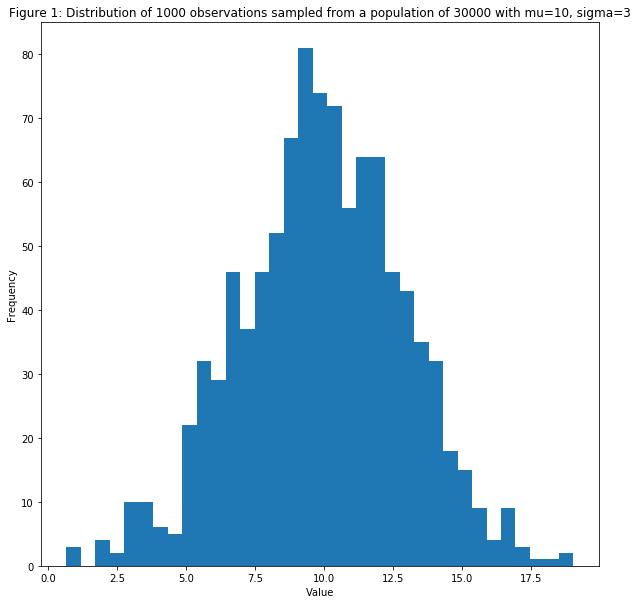

In [3]:
# Create population of 30,000 individuals
population = mod1(30000)
# Assume we are only able to ovserve 1,000 of these individuals
observations = population[np.random.randint(0, 30000, 1000)]

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.hist(observations, bins=35)
ax.set_xlabel('Value')
ax.set_ylabel('Frequency')
ax.set_title('Figure 1: Distribution of 1000 observations sampled from a population of 30000 with mu=10, sigma=3')

mu_obs = observations.mean()
mu_obs

In [4]:
def transition_model(x):
        params = [x[0], np.random.normal(x[1], 0.5, (1,))]
        if abs(params[1]) < 1e-4:
            params = transition_model(x)
        return params

def prior(x):
    if x[1] <= 0:
        return 0
    return 1

def manual_log_like_normal(x, data):
    return np.sum(-np.log(x[1] * np.sqrt(2*np.pi)) - ((data-x[0]) ** 2) / (2*x[1]**2)) 

def acceptance(x, x_new):
    if x_new > x:
        return True
    else:
        accept = np.random.uniform(0, 1)
        return (accept < np.exp(x_new - x))
    
def metropolis_hastings(likelihood_computer, prior, transition_model, param_init, iterations, data, acceptance_rule):
    x = param_init
    accepted = []
    rejected = []
    for i in range(iterations):
        # This will keep the original mu = x[0] constant and randomly generate a new sigma
        # print(x)
        x_new = transition_model(x)
        x_lik = likelihood_computer(x, data)
        x_new_lik = likelihood_computer(x_new, data)
        # if prior(x)=1 then log(1)=0 if prior(x)=0 then log(0)=-inf
        # thus if the sampled x <= 0 we won't select that value almost surely
        if (acceptance_rule(x_lik + np.log(prior(x)), x_new_lik + np.log(prior(x_new)))):
            x = x_new
            accepted.append(x_new)
        else:
            rejected.append(x_new)
        
    return np.array(accepted), np.array(rejected)

In [5]:
accepted, rejected = metropolis_hastings(manual_log_like_normal, prior, transition_model, [mu_obs, 0.1], 5000, observations, acceptance)

/Users/joshtracy/repos/school/bayesian-baseball-modeling/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in log
  del sys.path[0]
/Users/joshtracy/repos/school/bayesian-baseball-modeling/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log


In [6]:
accepted

array([[9.901761959934186, array([0.43101483])],
       [9.901761959934186, array([1.52154141])],
       [9.901761959934186, array([1.74870013])],
       ...,
       [9.901761959934186, array([3.02757078])],
       [9.901761959934186, array([3.00388165])],
       [9.901761959934186, array([2.96103485])]], dtype=object)

In [7]:
len(accepted)

890

## Computational Statistics in Python (https://people.duke.edu/~ccc14/sta-663/MCMC.html)

Toy example of estimating the bias of a coin given a sample consisting of n tosses to illustrate a few of the approaches.

### Analytical Solution

In [8]:
import os
import sys
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as st

plt.style.use('ggplot')
pd.set_option('display.max_columns', None)

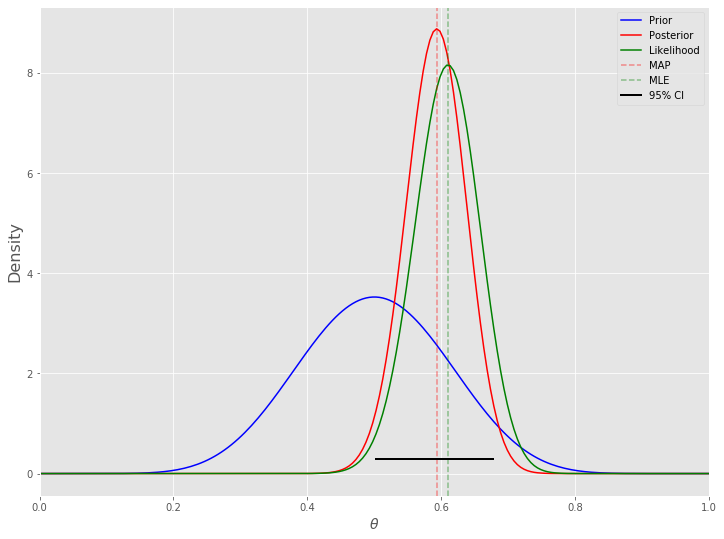

In [9]:
n = 100
h = 61
p = h/n
rv = st.binom(n, p)
mu = rv.mean()

a, b = 10, 10
prior = st.beta(a, b)
posterior = st.beta(h+a, n-h+b)
ci = posterior.interval(0.95)

thetas = np.linspace(0, 1, 200)

plt.figure(figsize=(12, 9))
plt.style.use('ggplot')
plt.plot(thetas, prior.pdf(thetas), label='Prior', c='blue')
plt.plot(thetas, posterior.pdf(thetas), label='Posterior', c='red')
plt.plot(thetas, n*st.binom(n, thetas).pmf(h), label='Likelihood', c='green')
plt.axvline((h+a-1)/(n+a+b-2), c='red', linestyle='dashed', alpha=0.4, label='MAP')
plt.axvline(mu/n, c='green', linestyle='dashed', alpha=0.4, label='MLE')
plt.xlim([0,1])
plt.axhline(0.3, ci[0], ci[1], c='black', linewidth=2, label='95% CI');
plt.xlabel(r'$\theta$', fontsize=14)
plt.ylabel('Density', fontsize=16)
plt.legend();

In [10]:
st.binom(n, p).mean()

61.0

### Numerical Integration

One simple way of numerical integration is to estimate the values on a grid of values for $\theta$. To calculate the posterior, we find the prior and the likelihood for each value of $\theta$, and for the marginal likelihood, we replace the intergral with the equivalent sum $$p(X)=\sum_{\theta^*}p(X|\theta^*)p(\theta^*)$$
One advantage of this is that the prior does not have to be conjugate, and so we are not restricted in our choice of an appropriate prior distribution. For example, the prior can be a mixture distribution or estimated emprirically from the data. The disadvantage, of course, is that this is computationally very expensive when we need to estimate multiple parameters, since the number of grid points grows as $O(n^d)$, where n defines the grid resolution and $d$ is the size of $\theta$.

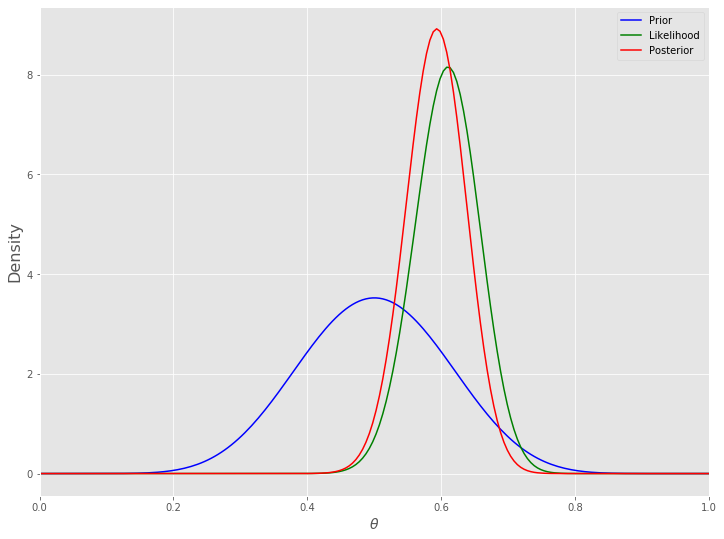

In [11]:
thetas = np.linspace(0, 1, 200)
prior = st.beta(a, b)

posterior = prior.pdf(thetas) * st.binom(n, thetas).pmf(h)
posterior /= (posterior.sum() / len(thetas))

plt.figure(figsize=(12, 9))
plt.plot(thetas, prior.pdf(thetas), label='Prior', c='blue')
plt.plot(thetas, n*st.binom(n, thetas).pmf(h), label='Likelihood', c='green')
plt.plot(thetas, posterior, label='Posterior', c='red')
plt.xlim([0, 1])
plt.xlabel(r'$\theta$', fontsize=14)
plt.ylabel('Density', fontsize=16)
plt.legend();

With MCMC, we draw samples from a (simple) proposal distribution so that each draw depends only on the state of the previous draw(i.e. the samples form a Markov chain). Under certain conditions, the Markov Chain will have a unique stationary distribution. In addition, not all samples are used - instead we set up acceptance criteria for each draw based on comparing successive states with respect to a target distribution that ensure that the stationary distribution is the posterior distribution of interest. The nice thing is that this target distribution only needs to be **proportional** to the posterior distribution, which means we don't need to evaluate the potentially intractable marginal likelihood, which is just a normalizing constant. We can find such a target distribution easily, since `posterior`$\propto$`likelihood`X`prior`. After some time, the Markov chain of accepted draws will converge to the stationary distribution, and we can use those samples as (correlated) draws from the posterior distribution, and find functions of the posterior distribution in the same way as for vanilla Monte Carlo integration.

In [12]:
def target(lik, prior, n, h, theta):
    if theta < 0 or theta > 1:
        return 0
    else:
        return lik(n, theta).pmf(h) * prior.pdf(theta)
    
n = 100
h = 61
a = 10
b = 10
lik = st.binom
prior = st.beta(a, b)
sigma = 0.3

naccept = 0
theta = 0.1
niters = 10000
samples = np.zeros(niters+1)
samples[0] = theta
for i in range(niters):
    theta_p = theta + st.norm(0, sigma).rvs()
    rho = min(1, target(lik, prior, n, h, theta_p) / target(lik, prior, n, h, theta))
    u = np.random.uniform()
    if u < rho:
        naccept += 1
        theta = theta_p
    samples[i+1] = theta
nmcmc = len(samples) // 2
print("Efficiency = ", naccept/niters)

Efficiency =  0.1858


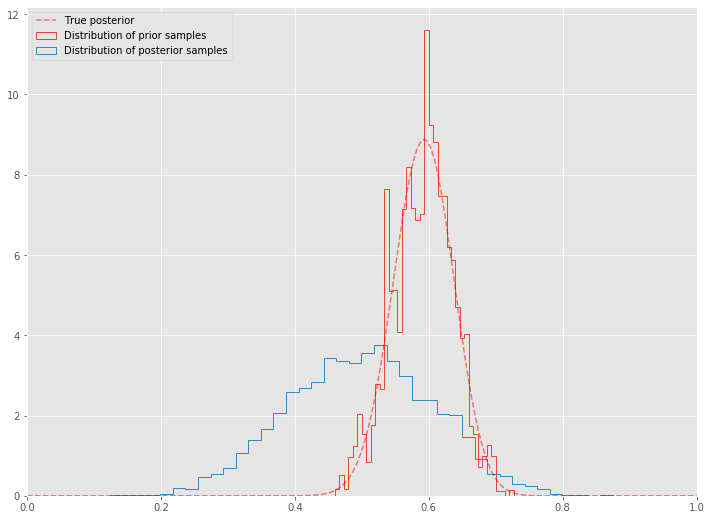

In [13]:
posterior = st.beta(h+a, n-h+b)

plt.figure(figsize=(12, 9))
plt.hist(samples[nmcmc:], 40, histtype='step', density=True, linewidth=1, label='Distribution of prior samples');
plt.hist(prior.rvs(nmcmc), 40, histtype='step', density=True, linewidth=1, label='Distribution of posterior samples');
plt.plot(thetas, posterior.pdf(thetas), c='red', linestyle='--', alpha=0.5, label='True posterior');
plt.xlim([0,1]);
plt.legend(loc='best');

Trace plots are often used to informally assess for stochastic convergence. Rigorous demonstration of convergence is an unsolved problem, but simple ideas such as running multiple chains and checking that they are converging to similar distributions are often employed in practice.

In [14]:
def mh_coin(niters, n, h, theta, lik, prior, sigma):
    samples = [theta]
    while len(samples) < niters:
        theta_p = theta + st.norm(0, sigma).rvs()
        rho = min(1, target(lik, prior, n, h, theta_p) / target(lik, prior, n, h, theta))
        u = np.random.uniform()
        if u < rho:
            theta = theta_p
        samples.append(theta)
    return samples


n = 100
h = 61
lik = st.binom
prior = st.beta(a, b)
sigma = 0.05
niters = 100

samples = [mh_coin(niters, n, h, theta, lik, prior, sigma) for theta in np.arange(0.1, 1, 0.2)]

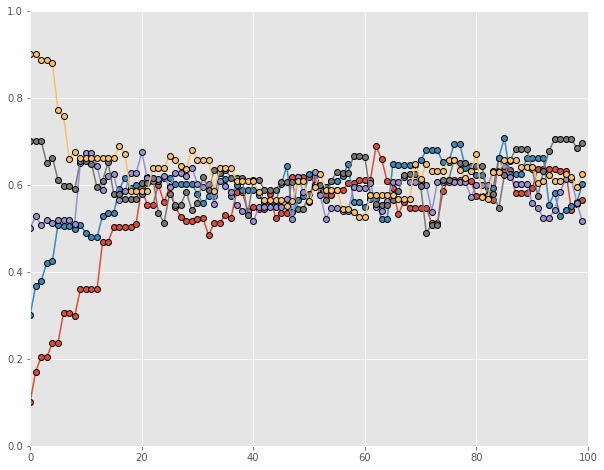

In [15]:
# Convergence of multiple chains

plt.figure(figsize=(10,8))
for sample in samples:
    plt.plot(sample, '-o', mec='black')
plt.xlim([0, niters])
plt.ylim([0, 1]);

## Gibbs Sampler

### Advantages of Gibbs sampling
- No need to tune proposal distribution
- Porposals are always accepted

### Disadvantages of Givvs sampling
- Need to be able to derive conditional probability distributions
- Need to be able to draw random samples from conditional probability distributions
- Can be very slow if parameters are correlated because you cannot take "diagonal" steps

### Example
We will use the toy example of estimating the bias of two coins given sample pairs ($z_1$, $n_1$) and ($z_2$, $n_2$) where $z_i$ is the number of heads in $n_i$ tosses for coin $i$.

In [16]:
def bern(theta, z, N):
    return np.clip(theta**z * (1-theta)**(N-z), 0, 1)

In [17]:
def bern2(theta1, theta2, z1, z2, N1, N2):
    return bern(theta1, z1, N1) * bern(theta2, z2, N2)

In [18]:
def make_thetas(xmin, xmax, n):
    xs = np.linspace(xmin, xmax, n)
    widths = (xs[1:] - xs[:-1]) / 2.0
    thetas = xs[:-1] + widths
    return thetas

In [23]:
def make_plots(X, Y, prior, likelihood, posterior, projection=None):
    fig, ax = plt.subplots(1,3, subplot_kw=dict(projection=projection, aspect='equal'), figsize=(12,3))
    if projection == '3d':
        ax[0].plot_surface(X, Y, prior, alpha=0.3, cmap=plt.cm.jet)
        ax[1].plot_surface(X, Y, likelihood, alpha=0.3, cmap=plt.cm.jet)
        ax[2].plot_surface(X, Y, posterior, alpha=0.3, cmap=plt.cm.jet)
    else:
        ax[0].contour(X, Y, prior)
        ax[1].contour(X, Y, likelihood)
        ax[2].contour(X, Y, posterior)
    ax[0].set_title('Prior')
    ax[1].set_title('Likelihood')
    ax[2].set_title('Posteior')
    plt.tight_layout()

In [24]:
thetas1 = make_thetas(0, 1, 101)
thetas2 = make_thetas(0, 1, 101)
X, Y = np.meshgrid(thetas1, thetas2)

### Analytic Solution

ValueError: Unknown projection '3d'

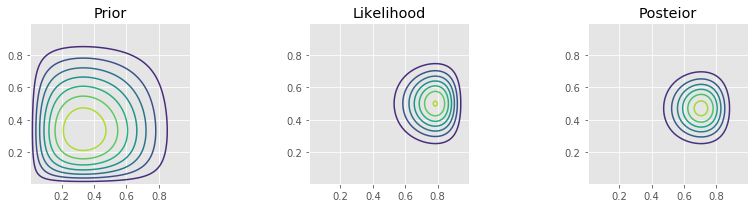

<Figure size 864x216 with 0 Axes>

In [25]:
a = 2
b = 3

z1 = 11
N1 = 14
z2 = 7
N2 = 14

prior = st.beta(a, b).pdf(X) * st.beta(a, b).pdf(Y)
likelihood = bern2(X, Y, z1, z2, N1, N2)
posterior = st.beta(a + z1, b + N1 - z1).pdf(X) * st.beta(a + z2, b + N2 - z2).pdf(Y)
make_plots(X, Y, prior, likelihood, posterior)
make_plots(X, Y, prior, likelihood, posterior, projection='3d')

In [28]:
np.meshgrid(thetas1, thetas2)

[array([[0.005, 0.015, 0.025, ..., 0.975, 0.985, 0.995],
        [0.005, 0.015, 0.025, ..., 0.975, 0.985, 0.995],
        [0.005, 0.015, 0.025, ..., 0.975, 0.985, 0.995],
        ...,
        [0.005, 0.015, 0.025, ..., 0.975, 0.985, 0.995],
        [0.005, 0.015, 0.025, ..., 0.975, 0.985, 0.995],
        [0.005, 0.015, 0.025, ..., 0.975, 0.985, 0.995]]),
 array([[0.005, 0.005, 0.005, ..., 0.005, 0.005, 0.005],
        [0.015, 0.015, 0.015, ..., 0.015, 0.015, 0.015],
        [0.025, 0.025, 0.025, ..., 0.025, 0.025, 0.025],
        ...,
        [0.975, 0.975, 0.975, ..., 0.975, 0.975, 0.975],
        [0.985, 0.985, 0.985, ..., 0.985, 0.985, 0.985],
        [0.995, 0.995, 0.995, ..., 0.995, 0.995, 0.995]])]

In [29]:
thetas1

array([0.005, 0.015, 0.025, 0.035, 0.045, 0.055, 0.065, 0.075, 0.085,
       0.095, 0.105, 0.115, 0.125, 0.135, 0.145, 0.155, 0.165, 0.175,
       0.185, 0.195, 0.205, 0.215, 0.225, 0.235, 0.245, 0.255, 0.265,
       0.275, 0.285, 0.295, 0.305, 0.315, 0.325, 0.335, 0.345, 0.355,
       0.365, 0.375, 0.385, 0.395, 0.405, 0.415, 0.425, 0.435, 0.445,
       0.455, 0.465, 0.475, 0.485, 0.495, 0.505, 0.515, 0.525, 0.535,
       0.545, 0.555, 0.565, 0.575, 0.585, 0.595, 0.605, 0.615, 0.625,
       0.635, 0.645, 0.655, 0.665, 0.675, 0.685, 0.695, 0.705, 0.715,
       0.725, 0.735, 0.745, 0.755, 0.765, 0.775, 0.785, 0.795, 0.805,
       0.815, 0.825, 0.835, 0.845, 0.855, 0.865, 0.875, 0.885, 0.895,
       0.905, 0.915, 0.925, 0.935, 0.945, 0.955, 0.965, 0.975, 0.985,
       0.995])

In [30]:
thetas2

array([0.005, 0.015, 0.025, 0.035, 0.045, 0.055, 0.065, 0.075, 0.085,
       0.095, 0.105, 0.115, 0.125, 0.135, 0.145, 0.155, 0.165, 0.175,
       0.185, 0.195, 0.205, 0.215, 0.225, 0.235, 0.245, 0.255, 0.265,
       0.275, 0.285, 0.295, 0.305, 0.315, 0.325, 0.335, 0.345, 0.355,
       0.365, 0.375, 0.385, 0.395, 0.405, 0.415, 0.425, 0.435, 0.445,
       0.455, 0.465, 0.475, 0.485, 0.495, 0.505, 0.515, 0.525, 0.535,
       0.545, 0.555, 0.565, 0.575, 0.585, 0.595, 0.605, 0.615, 0.625,
       0.635, 0.645, 0.655, 0.665, 0.675, 0.685, 0.695, 0.705, 0.715,
       0.725, 0.735, 0.745, 0.755, 0.765, 0.775, 0.785, 0.795, 0.805,
       0.815, 0.825, 0.835, 0.845, 0.855, 0.865, 0.875, 0.885, 0.895,
       0.905, 0.915, 0.925, 0.935, 0.945, 0.955, 0.965, 0.975, 0.985,
       0.995])

In [32]:
r = np.array([2, 3, 4])
l = np.array([5, 6, 7])

In [34]:
np.meshgrid(r, l)

[array([[2, 3, 4],
        [2, 3, 4],
        [2, 3, 4]]),
 array([[5, 5, 5],
        [6, 6, 6],
        [7, 7, 7]])]